# Using AI planning to explore data science pipelines

In [1]:
from __future__ import print_function
import sys
import os
import types

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../grammar2lale")))

# Clean output directory where we store planning and result files
os.system('rm -rf ../output')
os.system('mkdir -p ../output')


0

## 1. Start with a Data Science grammar, in EBNF format

In [2]:
# This is the grammar file we will use
GRAMMAR_FILE="../grammar/dsgrammar-subset-sklearn.bnf"

# Copy grammar to the output directory
os.system("cp " + GRAMMAR_FILE + " ../output/")

0

In [3]:
!cat ../output/dsgrammar-subset-sklearn.bnf

# Notation:
# - Anything between angle brackets <..> denotes a symbol in the grammar
# - The pipe symbol | denotes choice in the grammar
# - Terminals are operators and/or hyperparameters denoted by strings braced by double quotes ".."
# - { x }+ denotes one or more repetitions of x where x may be a symbol or terminals
# - String hyperparameters have single quotes '..' around them
# - __hpfloat denotes a float hyperparameter
# - __hpint denotes an integer hyperparameter


<start>  ::= <mm>
<mm>     ::= <dag> " >> " <est>
<dag>    ::= <tfm> | <tfm> " >> " <dag> | "((" <tfm> ") & (" <dag> ")) >> Concat()" |  "((" <est> ") & (" <dag> ")) >> Concat()" |   "( NoOp() & (" <dag> ")) >> Concat()"

# EST         
<est>    ::= <glm> | <dtc> | <ebm> | <gnb> | <knc> | <qda> 

# GLM
<glm>    ::= "LogisticRegression()"

# DTC
<dtc>    ::= "DecisionTreeClassifier()"

# EBM
<ebm>    ::= <rfc> | <gbc> | <etc>
# RFC
<rfc>    ::= "RandomForestClassifier()"
# GBC
<gbc>    ::= "GradientBoostingClassifier()

## 2. Convert the grammar into an HTN domain and problem and use [HTN to PDDL](https://github.com/ronwalf/HTN-Translation) to translate to a PDDL task

In [19]:
from grammar2lale import Grammar2Lale

# Generate HTN specifications
G2L = Grammar2Lale(grammar_file=GRAMMAR_FILE)
with open("../output/domain.htn", "w") as f:
    f.write(G2L.htn_domain);
with open("../output/problem.htn", "w") as f:
    f.write(G2L.htn_problem);


Generating HTN specification from grammar
Printing HTN domain


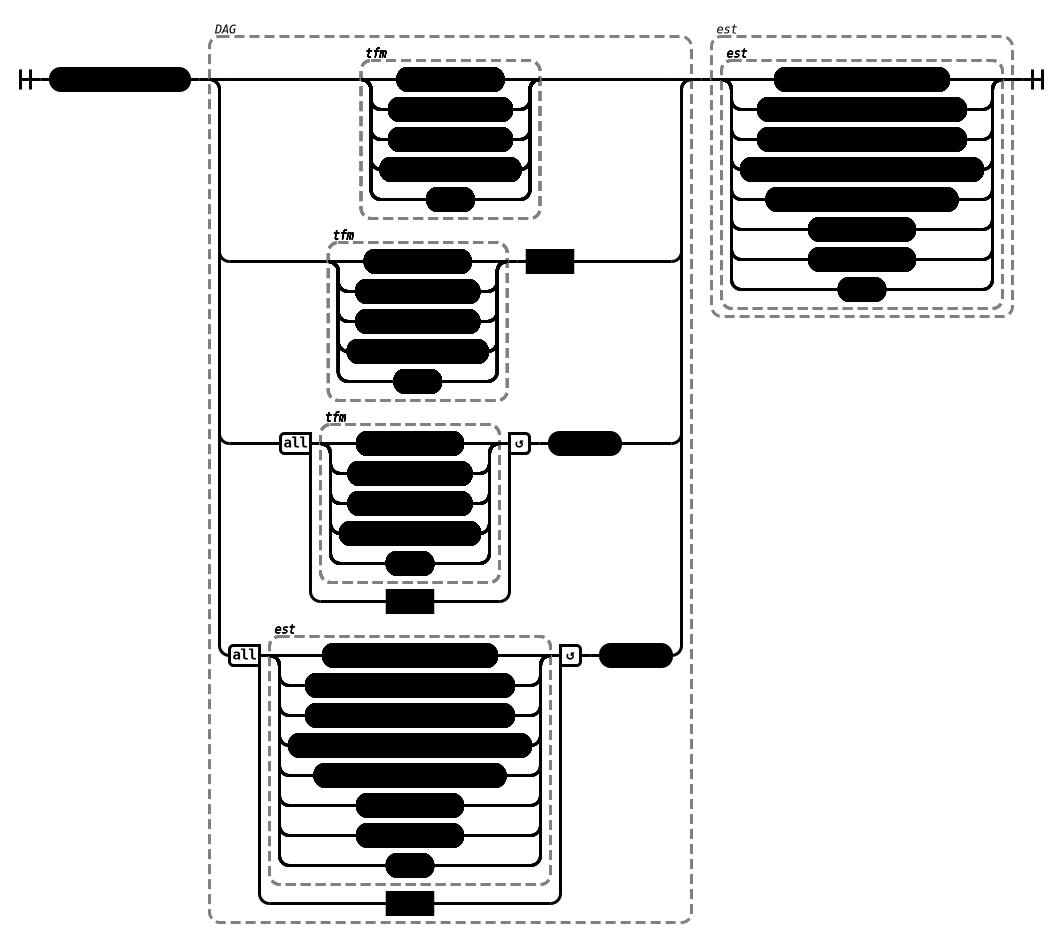

In [20]:
from grammarDiagram import sklearn_diagram
with open('../output/grammar.svg', 'w') as f:
    sklearn_diagram.writeSvg(f.write)
from IPython.core.display import SVG
SVG('../output/grammar.svg')

In [ ]:
!cat ../output/domain.htn

In [ ]:
!cat ../output/problem.htn

## 3. Extend the PDDL task by integrating soft constraints

In [21]:
import re
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# as a safety step, setting costs to 0 for any parts of the grammar that are non-identifiers (e.g., parens, etc.)
for token in G2L.htn.mapping:
    if not re.match('^[_a-zA-Z]', str(token)):
        G2L.costs[token] = 0
        
# prepare the list of possible constraints
constraint_options = G2L.get_selectable_constraints()
constraint_options.sort()    

# prepare a constraint selection form
interact_pipeline_params=interact.options(manual=True, manual_name='Generate PDDL')


pipelines = []
NUM_PIPELINES = 10
CONSTRAINTS = []


# This is the function that handles the constraint selection
@interact_pipeline_params(num_pipelines=widgets.IntSlider(value=10, min=1, max=100), 
                          constraints=widgets.SelectMultiple(options=constraint_options,
                                           description='Search constraints',
                                           rows=min(20, len(constraint_options))))
def select_pipeline_gen_params(num_pipelines, constraints):
    global pipelines
    global NUM_PIPELINES
    global CONSTRAINTS
    NUM_PIPELINES = num_pipelines
    CONSTRAINTS = list(constraints)
    G2L.create_pddl_task(NUM_PIPELINES, CONSTRAINTS)
    with open("../output/domain.pddl", "w") as f:
        f.write(G2L.last_task['domain'])
    with open("../output/problem.pddl", "w") as f:
        f.write(G2L.last_task['problem'])


interactive(children=(IntSlider(value=10, description='num_pipelines', min=1), SelectMultiple(description='Sea…

In [ ]:
!cat ../output/domain.pddl

In [ ]:
!cat ../output/problem.pddl

## 4. Use a planner to solve the planning task (in this case, [K*](https://github.com/ctpelok77/kstar) )

In [22]:
import json

G2L.run_pddl_planner()
with open("../output/first_planner_call.json", "w") as f:
    f.write(json.dumps(G2L.last_planner_object, indent=3))

Running the planner...
Created domain file in /tmp/4fbf2409-321a-4aa9-b3be-8fb4a921da0c/domain.pddl
Created problem file in /tmp/4fbf2409-321a-4aa9-b3be-8fb4a921da0c/problem.pddl
Running kstar /tmp/4fbf2409-321a-4aa9-b3be-8fb4a921da0c/domain.pddl /tmp/4fbf2409-321a-4aa9-b3be-8fb4a921da0c/problem.pddl --search "kstar(blind(),k=50,json_file_to_dump=result.json)"
Plans returned after 0.9218058586120605 seconds.


In [ ]:
!cat ../output/first_planner_call.json

## 5. Translate plans to [LALE](https://github.com/IBM/lale) Data Science pipelines

In [23]:
# Translate to pipelines
pipelines = G2L.translate_to_pipelines(NUM_PIPELINES)

from pipeline_optimizer import PipelineOptimizer
from sklearn.datasets import load_iris

from lale.helpers import to_graphviz
from lale.lib.sklearn import *
from lale.lib.lale import ConcatFeatures as Concat
from lale.lib.lale import NoOp
from lale.lib.sklearn import KNeighborsClassifier as KNN
from lale.lib.sklearn import OneHotEncoder as OneHotEnc
from lale.lib.sklearn import Nystroem
from lale.lib.sklearn import PCA

optimizer = PipelineOptimizer(load_iris(return_X_y=True))
# instantiate LALE objects from pipeline definitions
LALE_pipelines = [optimizer.to_lale_pipeline(p) for p in pipelines]

# Display selected pipeline
def show_pipeline(pipeline):
    print("Displaying pipeline " + pipeline['id'] + ", with cost " + str(pipeline['score']))
    print(pipeline['pipeline'])
    print('==================================================================================')
    print()
    print()
    print()
    display(to_graphviz(pipeline['lale_pipeline']))

display_pipelines = [[p['pipeline'], p] for p in LALE_pipelines]    
    
interact(show_pipeline, pipeline=display_pipelines)

Translating plans to LALE pipelines.


interactive(children=(Dropdown(description='pipeline', options=(['PCA() >> LogisticRegression()', {'id': '6a19…

<function __main__.show_pipeline(pipeline)>

In [38]:
!pip install 'liac-arff>=2.4.0'

  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11730 sha256=e047b877b395d00fd1d84e607af797c45aa12616a2235c627f9f45bf3a8f6f64
  Stored in directory: /home/oudrea/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built liac-arff


## 6. Optimize one of the pipelines on a small dataset

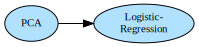

None

In [55]:
from lale.lib.lale import Hyperopt
import lale.datasets.openml
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

PIPELINE_IDX = 0

display(to_graphviz(LALE_pipelines[PIPELINE_IDX]['lale_pipeline']))



In [56]:
opt = Hyperopt(
    estimator=LALE_pipelines[PIPELINE_IDX]['lale_pipeline'],
    max_evals=20,
    scoring='accuracy'
)
X, y = load_iris(return_X_y=True)
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=5489
)

pd.options.display.max_columns=None
ds=pd.concat([pd.Series(y).head(5), pd.DataFrame(data=X).head(5)], axis=1)
ds.columns=['species', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']
display(ds)

,species,sepal_length,sepal_width,petal_length,petal_width
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


In [57]:
trained_pipeline = opt.fit(train_X, train_y)

predictions = trained_pipeline.predict(test_X)
best_accuracy = accuracy_score(test_y, [round(pred) for pred in predictions])
print('Best accuracy: ' + str(best_accuracy))
ds2 = pd.concat([pd.Series(predictions), pd.Series(test_y), pd.DataFrame(data=test_X)], axis=1)
ds2.columns=['predicted species', 'species', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']
display(ds2)

100%|██████████| 20/20 [00:05<00:00,  3.89trial/s, best loss: -0.9583333333333334]
Best accuracy: 0.9666666666666667


,predicted species,species,sepal_length,sepal_width,petal_length,petal_width
0,1,1,5.7,2.8,4.1,1.3
1,1,1,6.6,3.0,4.4,1.4
2,2,2,7.7,2.8,6.7,2.0
3,1,1,6.6,2.9,4.6,1.3
4,2,2,6.9,3.1,5.4,2.1
5,0,0,4.9,3.6,1.4,0.1
6,0,0,5.4,3.4,1.5,0.4
7,1,1,6.4,3.2,4.5,1.5
8,2,2,6.5,3.2,5.1,2.0
9,1,1,6.8,2.8,4.8,1.4


## 7. Train hyperparameters and evaluate the resulting LALE pipelines

In [24]:
trained_pipelines, dropped_pipelines = optimizer.evaluate_and_train_pipelines(pipelines)

Plan 1/10
Starting to optimize PCA() >> LogisticRegression()
100%|██████████| 20/20 [00:06<00:00,  2.99trial/s, best loss: -0.95]             
Fit completed.
Predict completed.
Best accuracy: 0.9733333333333334
Completed optimization for PCA() >> LogisticRegression()
Plan 2/10
Starting to optimize PCA() >> GaussianNB()
100%|██████████| 20/20 [00:06<00:00,  2.91trial/s, best loss: -0.9199999999999999]
Fit completed.
Predict completed.
Best accuracy: 0.9333333333333333
Completed optimization for PCA() >> GaussianNB()
Plan 3/10
Starting to optimize PCA() >> DecisionTreeClassifier()
100%|██████████| 20/20 [00:09<00:00,  2.07trial/s, best loss: -0.8800000000000001]
Fit completed.
Predict completed.
Best accuracy: 0.9466666666666667
Completed optimization for PCA() >> DecisionTreeClassifier()
Plan 4/10
Starting to optimize PCA() >> KNeighborsClassifier()
100%|██████████| 20/20 [00:10<00:00,  1.86trial/s, best loss: -0.97]             
Fit completed.
Predict completed.
Best accuracy: 1.0
Comp

In [25]:
from IPython.display import HTML
from tabulate import tabulate
from lale.pretty_print import to_string

def show_pipeline_accuracy(tp):
    pipeline_table = [[to_string(p['trained_pipeline']).replace('\n', '<br/>'), str(p['best_accuracy'])] for p in tp]
    display(HTML(tabulate(pipeline_table, headers=['Pipeline', 'Accuracy'], tablefmt='html')))


show_pipeline_accuracy(trained_pipelines)

Pipeline,Accuracy
"from lale.lib.lale import Hyperoptfrom sklearn.decomposition import PCAfrom sklearn.linear_model import LogisticRegressionimport lalelale.wrap_imported_operators()pipeline = Hyperopt( estimator=PCA() >> LogisticRegression(), max_evals=20, scoring=""r2"")",0.973333
"from lale.lib.lale import Hyperoptfrom sklearn.decomposition import PCAfrom sklearn.naive_bayes import GaussianNBimport lalelale.wrap_imported_operators()pipeline = Hyperopt( estimator=PCA() >> GaussianNB(), max_evals=20, scoring=""r2"")",0.933333
"from lale.lib.lale import Hyperoptfrom sklearn.decomposition import PCAfrom sklearn.tree import DecisionTreeClassifierimport lalelale.wrap_imported_operators()pipeline = Hyperopt( estimator=PCA() >> DecisionTreeClassifier(), max_evals=20, scoring=""r2"")",0.946667
"from lale.lib.lale import Hyperoptfrom sklearn.decomposition import PCAfrom sklearn.neighbors import KNeighborsClassifier as KNNimport lalelale.wrap_imported_operators()pipeline = Hyperopt(estimator=PCA() >> KNN(), max_evals=20, scoring=""r2"")",1
"from lale.lib.lale import Hyperoptfrom sklearn.decomposition import PCAfrom sklearn.discriminant_analysis import QuadraticDiscriminantAnalysisimport lalelale.wrap_imported_operators()pipeline = Hyperopt( estimator=PCA() >> QuadraticDiscriminantAnalysis(), max_evals=20, scoring=""r2"",)",0.98
"from lale.lib.lale import Hyperoptfrom sklearn.decomposition import PCAfrom sklearn.ensemble import ExtraTreesClassifierimport lalelale.wrap_imported_operators()pipeline = Hyperopt( estimator=PCA() >> ExtraTreesClassifier(), max_evals=20, scoring=""r2"")",0.953333
"from lale.lib.lale import Hyperoptfrom sklearn.decomposition import PCAfrom sklearn.ensemble import GradientBoostingClassifierimport lalelale.wrap_imported_operators()pipeline = Hyperopt( estimator=PCA() >> GradientBoostingClassifier(), max_evals=20, scoring=""r2"",)",1
"from lale.lib.lale import Hyperoptfrom sklearn.decomposition import PCAfrom sklearn.ensemble import RandomForestClassifierimport lalelale.wrap_imported_operators()pipeline = Hyperopt( estimator=PCA() >> RandomForestClassifier(), max_evals=20, scoring=""r2"")",1
"from lale.lib.lale import Hyperoptfrom sklearn.preprocessing import Normalizerfrom sklearn.decomposition import PCAfrom sklearn.linear_model import LogisticRegressionimport lalelale.wrap_imported_operators()pipeline = Hyperopt( estimator=Normalizer() >> PCA() >> LogisticRegression(), max_evals=20, scoring=""r2"",)",0.953333
"from lale.lib.lale import Hyperoptfrom sklearn.decomposition import PCAfrom sklearn.preprocessing import RobustScalerfrom sklearn.tree import DecisionTreeClassifierimport lalelale.wrap_imported_operators()pipeline = Hyperopt( estimator=PCA() >> RobustScaler() >> DecisionTreeClassifier(), max_evals=20, scoring=""r2"",)",0.946667


## 8. Use pipeline accuracy to compute new PDDL action costs

In [26]:
feedback = optimizer.get_feedback(trained_pipelines)
G2L.feedback(feedback)
costs_table = [[str(k), G2L.costs[k]] for k in G2L.costs.keys()]
display(HTML(tabulate(costs_table, headers=['Pipeline element', 'Computed cost'], tablefmt='html')))

Pipeline element,Computed cost
PCA(),73
>>,0
LogisticRegression(),78
GaussianNB(),101
DecisionTreeClassifier(),90
KNeighborsClassifier(),50
QuadraticDiscriminantAnalysis(),65
ExtraTreesClassifier(),85
GradientBoostingClassifier(),50
RandomForestClassifier(),50


## 9. Invoke planner again on updated PDDL task and translate to pipelines

In [27]:
new_pipelines = G2L.get_plans(num_pipelines=NUM_PIPELINES, constraints=CONSTRAINTS)

with open('../output/domain_after_feedback.pddl', 'w') as f:
    f.write(G2L.last_task['domain'])
with open('../output/problem_after_feedback.pddl', 'w') as f:
    f.write(G2L.last_task['problem'])
with open('../output/second_planner_call.json', 'w') as f:
    f.write(json.dumps(G2L.last_planner_object, indent=3))

def build_and_show_new_table():
    new_pipeline_table = [[pipelines[idx]['pipeline'], new_pipelines[idx]['pipeline']] for idx in range(min(len(pipelines), len(new_pipelines)))]
    display(HTML(tabulate(new_pipeline_table, headers=['First iteration', 'After feedback'], tablefmt='html')))

build_and_show_new_table()

Generating PDDL description...
Obtaining 10 plans with constraints ['PCA()']
Running the planner...
Created domain file in /tmp/51cf31e7-e235-42a4-b517-743603264758/domain.pddl
Created problem file in /tmp/51cf31e7-e235-42a4-b517-743603264758/problem.pddl
Running kstar /tmp/51cf31e7-e235-42a4-b517-743603264758/domain.pddl /tmp/51cf31e7-e235-42a4-b517-743603264758/problem.pddl --search "kstar(blind(),k=50,json_file_to_dump=result.json)"
Plans returned after 0.7981829643249512 seconds.
Translating plans to LALE pipelines.


First iteration,After feedback
PCA() >> LogisticRegression(),PCA() >> KNeighborsClassifier()
PCA() >> GaussianNB(),PCA() >> GradientBoostingClassifier()
PCA() >> DecisionTreeClassifier(),PCA() >> RandomForestClassifier()
PCA() >> KNeighborsClassifier(),PCA() >> QuadraticDiscriminantAnalysis()
PCA() >> QuadraticDiscriminantAnalysis(),PCA() >> LogisticRegression()
PCA() >> ExtraTreesClassifier(),PCA() >> ExtraTreesClassifier()
PCA() >> GradientBoostingClassifier(),PCA() >> DecisionTreeClassifier()
PCA() >> RandomForestClassifier(),PCA() >> GaussianNB()
Normalizer() >> PCA() >> LogisticRegression(),MinMaxScaler() >> PCA() >> KNeighborsClassifier()
PCA() >> RobustScaler() >> DecisionTreeClassifier(),PCA() >> StandardScaler() >> KNeighborsClassifier()


In [ ]:
!cat ../output/domain_after_feedback.pddl

In [ ]:
!cat ../output/problem_after_feedback.pddl